In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("poster")

<div class='alert alert-info'>
<h3> Prepare the train_users table </h3>
</div>

In [2]:
train_users = pd.read_csv('csvdata/train_users_2.csv')
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
# clean up the timestamps in the train_users dataframe 

train_users.timestamp_first_active = pd.to_datetime(train_users.timestamp_first_active.astype(str))
train_users.date_first_booking = pd.to_datetime(train_users.date_first_booking)
train_users.date_account_created = pd.to_datetime(train_users.date_account_created)

train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [4]:
len(train_users.id.unique()) == len(train_users)

True

<div class='alert alert-info'>

No users are repeated in the train_users table. 

</div>

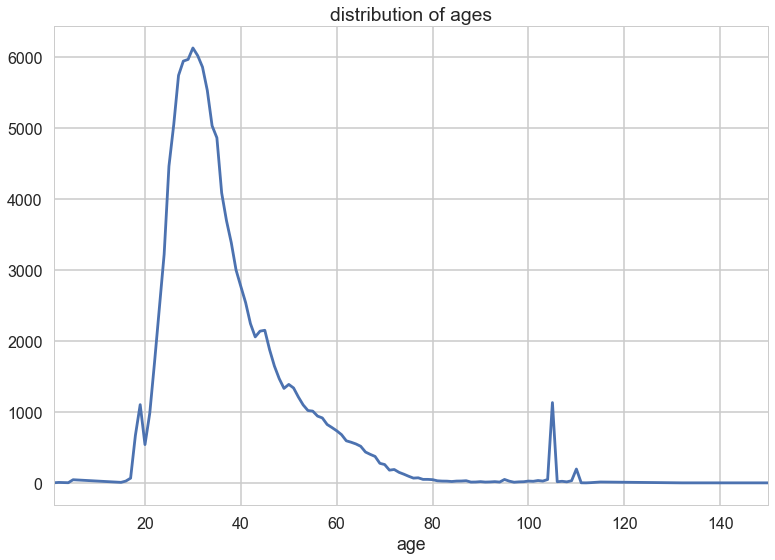

In [5]:
# Get rid of age values bigger than 200 and plot the distribution 

train_users.age[train_users.age < 200].value_counts().sort_index().plot()
plt.title('distribution of ages')
plt.xlabel('age')
None

<div class='alert alert-info'>

<p> We observe that there is an unexpected spike in ages between 100 and 120. We will later remove those age values. Also, some values in the age column are years such as 1949 or 2014. These values will also be removed later. Perhaps this indicates non-sanitized forms, or that forms are collecting the data in incompatible ways depending on the platform - such as one form collecting age and another collecting birth dates. </p>

</div>

In [6]:
# clear out suspiciously large age values

train_users.age.loc[train_users.age > 100] = np.nan

/Users/partha/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# how many missing values in each column

train_users.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         90335
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

<div class='alert alert-info'>

There are a number of missing values, for date_first_booking, age and first_affiliate_tracked. It turns out that the missing date_first_booking values are exactly the users who made no booking: 

</div>

In [8]:
# only keep the users for whom date_account_created matches timestamp_first_active 
# the users for whom the dates do not match likely represent bad data or early adoption data. 

train_users = train_users[train_users.timestamp_first_active.dt.date == train_users.date_account_created.dt.date]

In [9]:
# separate the date_first_booking column as a column of 1/0
# drop all the date_first_booking values - they're not present in the test_users table. 

y_users = train_users.date_first_booking.notnull().astype(int)

#train_users = train_users.drop('date_first_booking', axis=1)

In [10]:
np.array_equal((train_users.country_destination != 'NDF'), y_users)

True

<div class='alert alert-info'>

<h3>Observation: </h3>
<p>The users for whom the destination is not found are exactly the same as the users for whom the date of first booking is missing. </p>

</div>

In [11]:
# create features: year, month and dayofweek from date_account_created. 

train_users.loc[:,'year'] = train_users.date_account_created.dt.year.astype('category')
train_users.loc[:,'month'] = train_users.date_account_created.dt.month.astype('category')
train_users.loc[:,'dayofweek'] = train_users.date_account_created.dt.dayofweek.astype('category')

# mark a the following columns as categorical data
mylist = ['gender', 'signup_method', 'language', 'affiliate_channel', 
          'affiliate_provider', 'first_affiliate_tracked', 'signup_flow', 
          'signup_app', 'first_device_type', 'first_browser']
for x in mylist:
    train_users.loc[:,x] = train_users[x].astype('category')

#add seasons
# mydict = {2:'spring', 3:'spring', 4:'spring', 
#           5:'summer', 6:'summer', 7:'summer', 
#           8:'fall', 9:'fall', 10:'fall',
#           11:'winter', 12:'winter', 1:'winter'}
# train_users.loc[:,'season'] = train_users.date_account_created.dt.month.apply(lambda x: mydict[x]).astype('category')

# only keep the users from 2014 for now - the test set only involves the users from 2014 
#train_users = train_users[(train_users.year == 2014)]

# Conversion Rate Analysis

In [12]:
def plot_conversion_rate(column_name, kind='bar'):
    ndf = train_users.groupby([column_name, 'country_destination']).size().unstack().NDF
    total = train_users.groupby([column_name]).size()
    s = 100.0 - 100.0 * ndf / total 
    s.sort_values(ascending=False).plot(kind=kind)
    plt.title('conversion rate')
    plt.ylabel('percent converted')
    plt.xlabel(column_name)

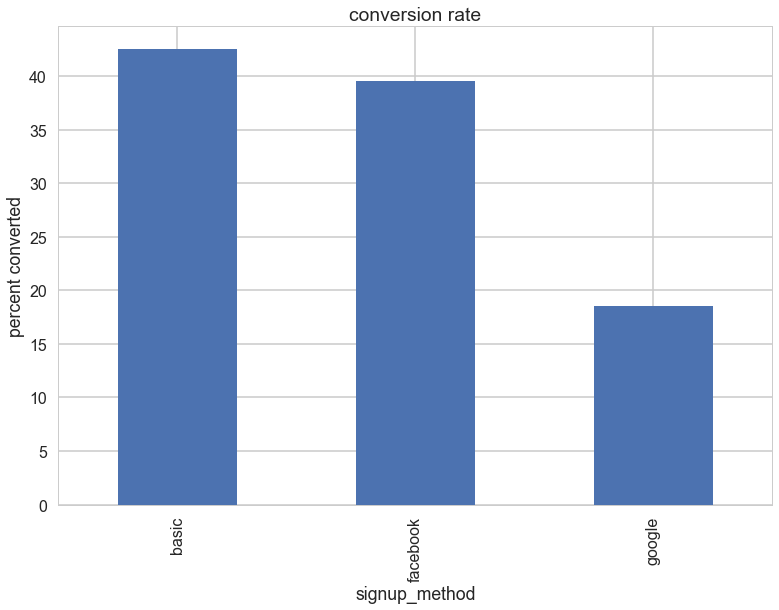

In [13]:
plot_conversion_rate('signup_method')

<div class='alert alert-info'>

Those who signup from Google have half the conversion rate compared to those who signup directly or from Facebook. The success of Facebook compared to Google could be because of social proof of endorsement. It would be a good idea to implement extraneous social proof for the users who signup from Google. 

</div>

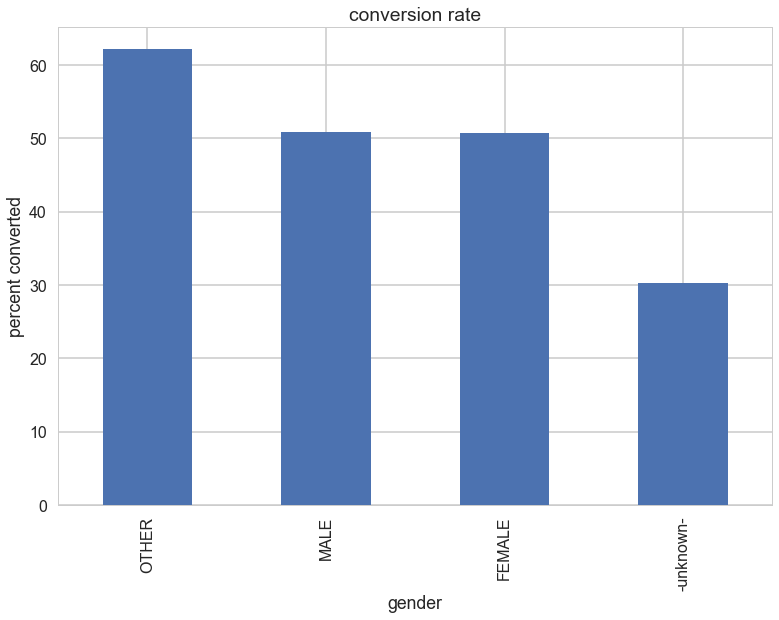

In [14]:
plot_conversion_rate('gender')

<div class='alert alert-info'>

No difference between the conversion rates of Males and Females. Perhaps those who refuse to disclose their gender are too concerned about privacy or are receiveing generic marketing. It may be a good idea to reassure them about protecting their privacy instead of generic gender-related marketing. 

</div>

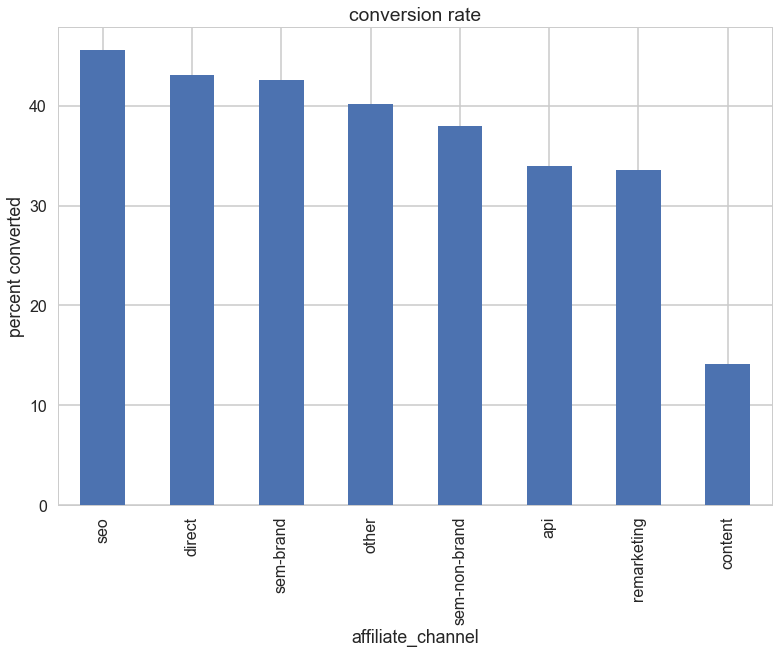

In [15]:
plot_conversion_rate('affiliate_channel')

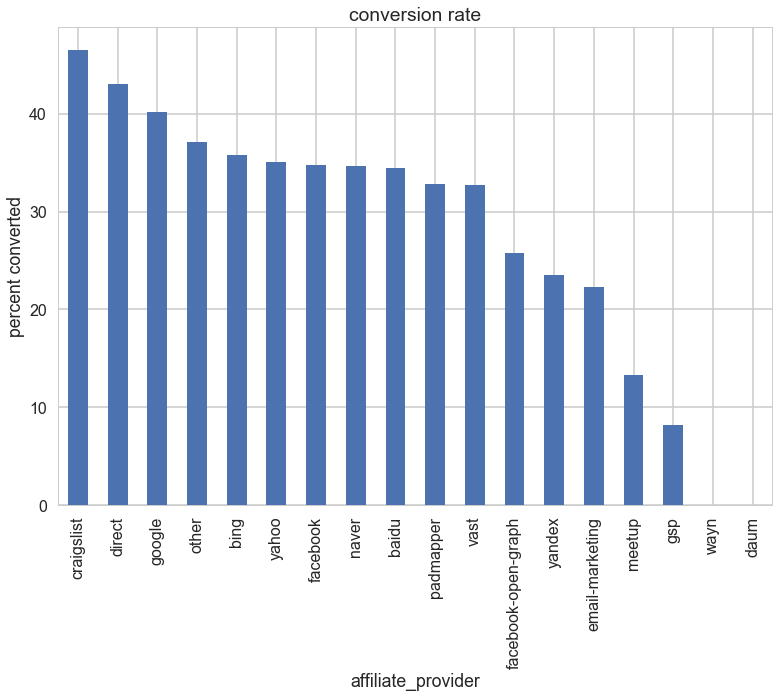

In [16]:
plot_conversion_rate('affiliate_provider')

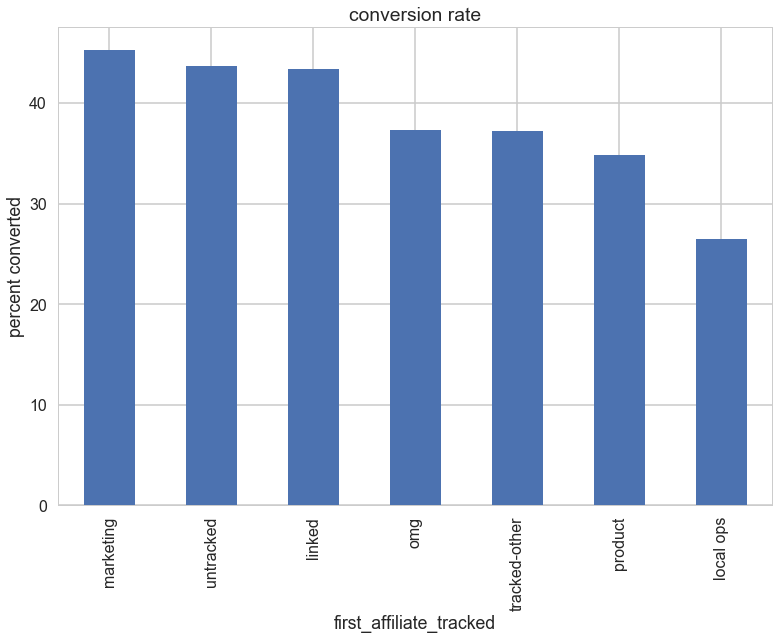

In [17]:
plot_conversion_rate('first_affiliate_tracked')

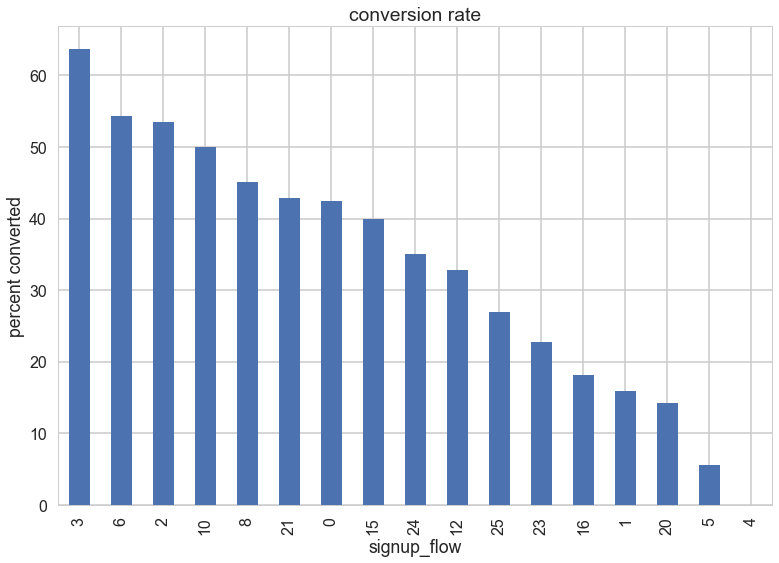

In [18]:
plot_conversion_rate('signup_flow')

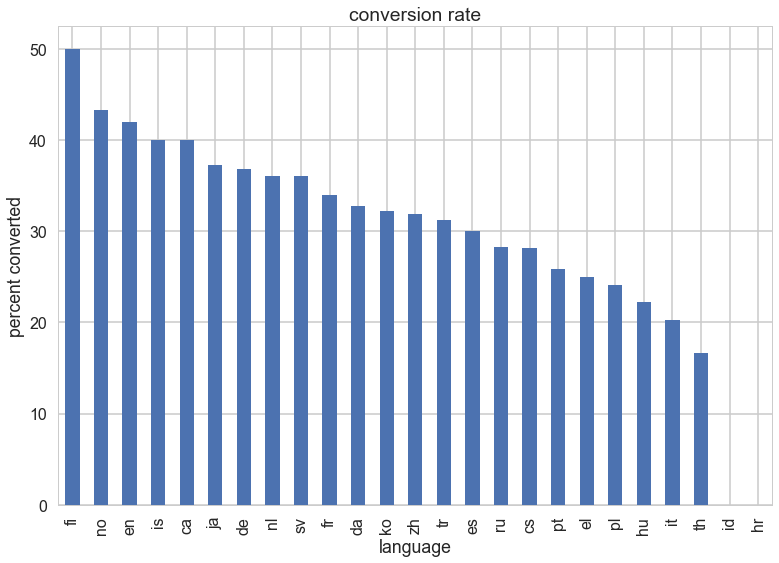

In [19]:
plot_conversion_rate('language')

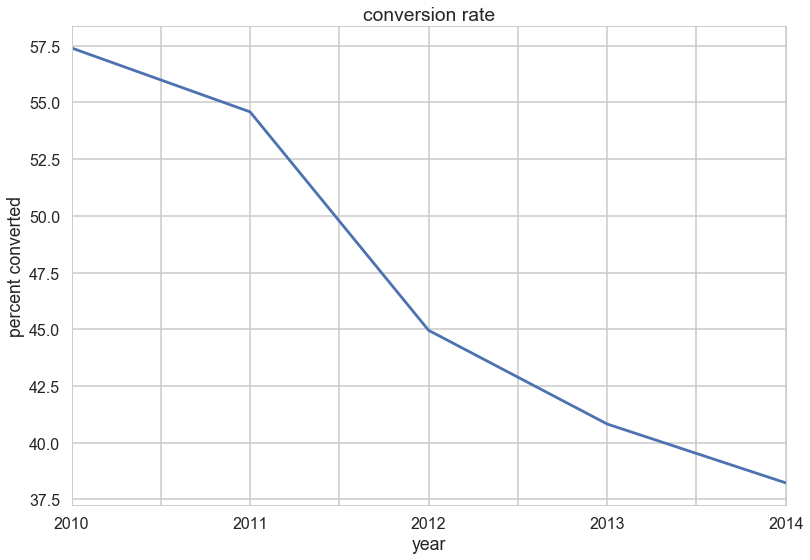

In [20]:
plot_conversion_rate('year', kind='line')

<div class='alert alert-info'>

It appears that the conversion rate is falling consistently. This could simply be an artifact of more people being aware of Airbnb, rather than reflecting any true problems. 

</div>

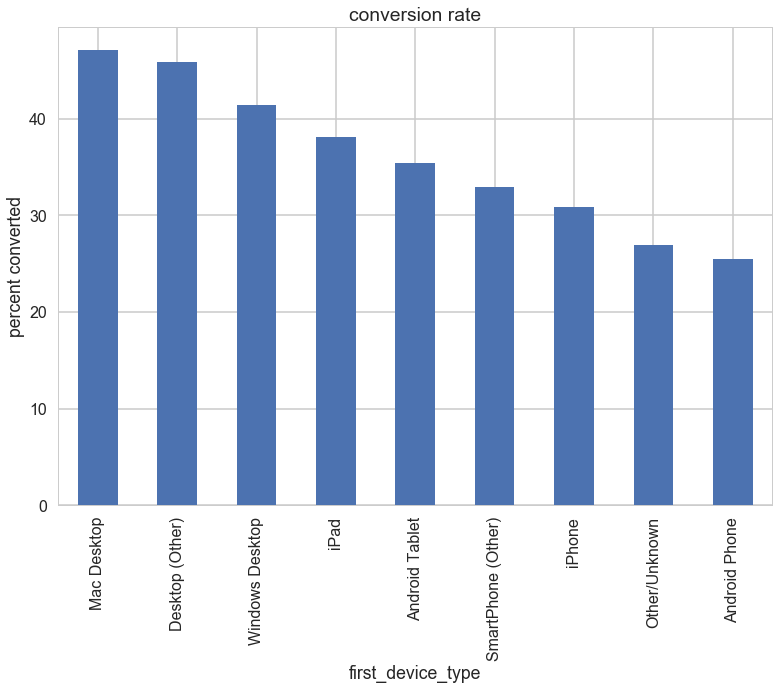

In [22]:
plot_conversion_rate('first_device_type')

<div class='alert alert-info'>

Bigger screens seem to correlate with higher conversion rate and smaller screens seem to correlate with lower conversion rates. This suggests that the mobile website interface or the mobile app is not as well designed as the desktop website. 

</div>

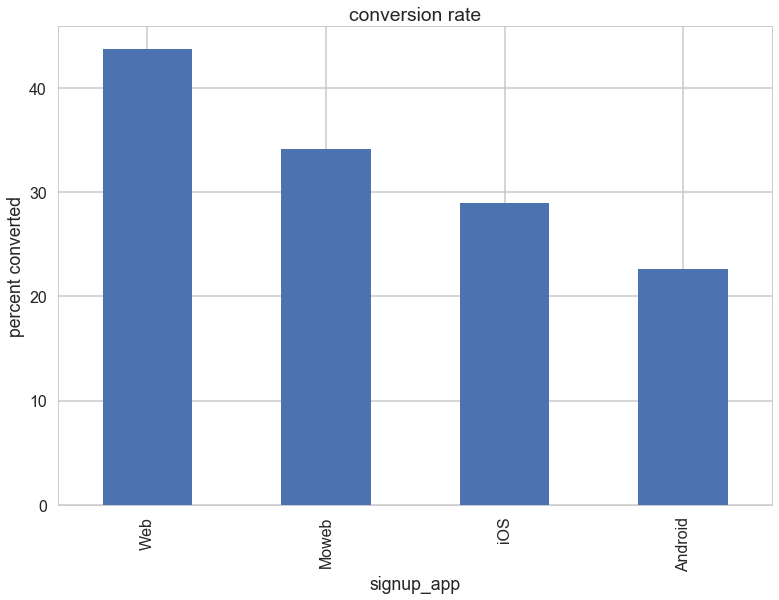

In [23]:
plot_conversion_rate('signup_app')

<div class='alert alert-info'>

Moweb seems to be more effective in converting users compared to the standard iOS and Android apps. 

</div>

In [24]:
train_users.columns

Index([u'id', u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser', u'country_destination', u'year',
       u'month', u'dayofweek'],
      dtype='object')

# Seasonal patterns

In [25]:
def plot_monthly_traffic(country):
    df = train_users[train_users.country_destination == country]
    df.groupby(df.date_first_booking.dt.month).size().plot(kind='bar')

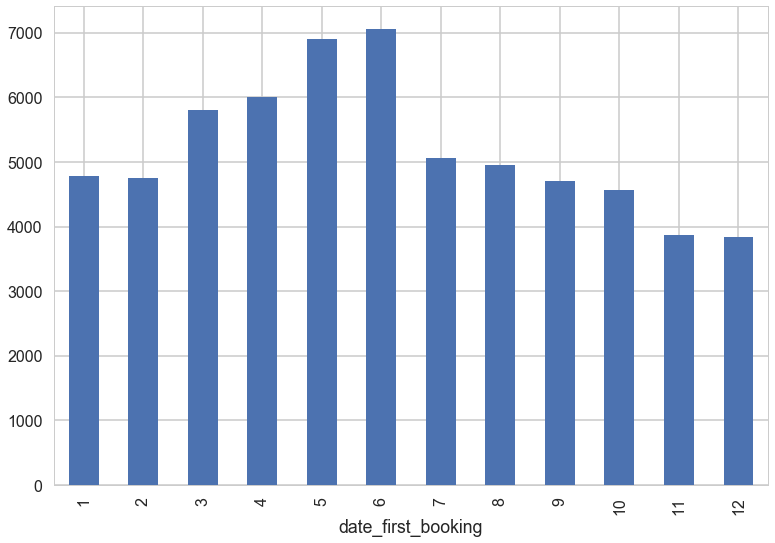

In [27]:
plot_monthly_traffic('US')

<div class='alert alert-info'>

Users who travel within the USA seem to like traveling in the spring/summer and hate traveling in the winter, as expected by the weather patterns. 

</div>

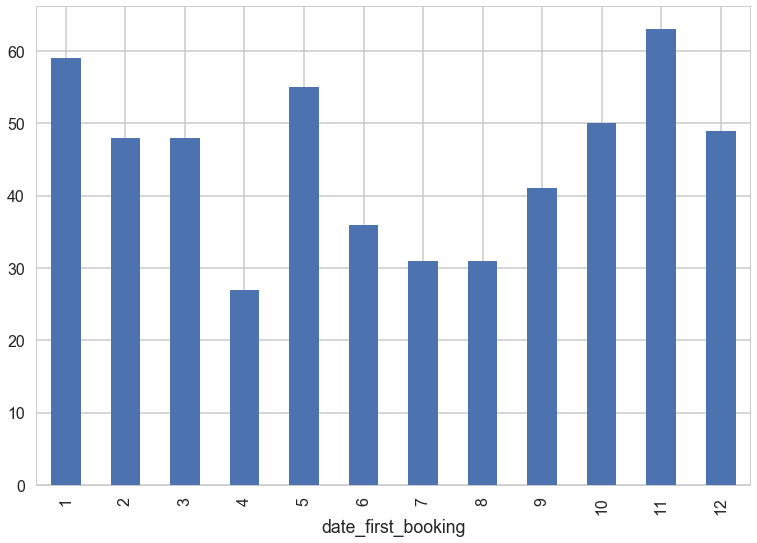

In [28]:
plot_monthly_traffic('AU')

<div class='alert alert-info'>

Users who travel to Australia seem to prefer to go there when it's warm there. The spike in May may be explained by the summer breaks of schools and colleges. 

</div>

In [29]:
train_users.country_destination.unique()

array(['US', 'NDF', 'FR', 'CA', 'ES', 'GB', 'other', 'IT', 'PT', 'NL',
       'DE', 'AU'], dtype=object)